In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
seed: int = 42

In [5]:
def read_csv(file: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(os.getcwd(), f"dataset/{file}"))
    return df

In [6]:
titanic = read_csv("train_engineered.csv")
titanic_copy = titanic.copy()

In [7]:
titanic_copy.columns.values

array(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'Age_present', 'Embarked_present'],
      dtype=object)

In [8]:
titanic_copy["Embarked"] = titanic_copy['Embarked'].replace(np.nan, "S")

In [9]:
titanic_copy['Is_child'] = np.select([titanic_copy['title'].str.lower() == 'master'], ['Y'], 'N')
titanic_copy['Nb_Fmly_Mem'] = titanic_copy['SibSp'].fillna(0) + titanic_copy['Parch'].fillna(0)

In [10]:
young_men = titanic_copy.loc[titanic_copy['title'] == "Master"]
adult_men = titanic_copy.loc[(titanic_copy['title'] != "Master") & (titanic_copy['Sex'] == "male")]


print(f"Median Boy Age -> {young_men['Age'].median()}. Median Men Age -> {adult_men['Age'].median()}")


Median Boy Age -> 3.5. Median Men Age -> 30.0


In [11]:
first_class = titanic_copy.loc[titanic_copy['Pclass'] == 1]
second_class = titanic_copy.loc[titanic_copy['Pclass'] == 2]
third_class = titanic_copy.loc[titanic_copy['Pclass'] == 3]

print(f"Median fare paid per class. 1st class -> {first_class['Fare'].median()}, 2nd class -> {second_class['Fare'].median()}, 3rd class -> {third_class['Fare'].median()}")

Median fare paid per class. 1st class -> 60.287499999999994, 2nd class -> 14.25, 3rd class -> 8.05


In [12]:
young_men['Age'].isnull().sum()

4

In [13]:
adult_men['Age'].isnull().sum()

120

In [14]:
titanic_copy['Age'].isnull().sum()

177

In [15]:
titanic_copy["Age"] = np.where(titanic_copy["Sex"] == "female", 28, titanic_copy["Age"],) # replace all women
titanic_copy['Age'].isnull().sum()

124

In [16]:
titanic_copy["Age"] = np.where(titanic_copy["title"] == "Master", young_men["Age"].median(), titanic_copy["Age"]) # replace all young boys (title == master)
titanic_copy['Age'].isnull().sum()

120

In [17]:
titanic_copy["Age"] = np.where(titanic_copy["Sex"] == "male", adult_men["Age"].median(), titanic_copy["Age"]) # replace all men title != "Master"
titanic_copy['Age'].isnull().sum()

0

In [18]:
titanic_copy.isnull().any()

Survived            False
Pclass              False
Sex                 False
Age                 False
SibSp               False
Parch               False
Fare                False
Embarked            False
title               False
Age_present         False
Embarked_present    False
Is_child            False
Nb_Fmly_Mem         False
dtype: bool

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(titanic_copy, test_size=0.2, random_state=seed, stratify=titanic_copy[["Survived", "Pclass", "Sex"]])

In [20]:
y_train = train["Survived"]
del train["Survived"]

y_test = test["Survived"]
del test["Survived"]
    

In [21]:
titanic_copy.isna().any()

Survived            False
Pclass              False
Sex                 False
Age                 False
SibSp               False
Parch               False
Fare                False
Embarked            False
title               False
Age_present         False
Embarked_present    False
Is_child            False
Nb_Fmly_Mem         False
dtype: bool

In [22]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, FunctionTransformer


numeric_features = ["Age", "Fare"]
ordinal_features = ["Pclass"]
categorical_features = ["Sex", "SibSp", "Parch", "Embarked", "title", "Embarked_present", "Is_child", "Age_present"]

numeric_transformer = Pipeline([("scaler", RobustScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="error")
ordinal_transformer = OrdinalEncoder(handle_unknown="error")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features),
    ]
)

In [23]:
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

logit = Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LogisticRegression(random_state=seed))])
logit.fit(train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'SibSp', 'Parch',
                                                   'Embarked', 'title',
                                                   'Embarked_present',
                                                   'Is_child', 'Age_present']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['Pclass'])])),
                ('sampling', SMOTE()),
                ('classifier', LogisticRegression(random_state=42))])

In [24]:
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier

classifiers = {
    "logit": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LogisticRegression(random_state=seed, n_jobs=-1))]),
    "rf": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", RandomForestClassifier(random_state=seed, n_jobs=-1))]),
    "lbgm": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LGBMClassifier(random_state=seed, n_jobs=-1))]),
    "neural": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", MLPClassifier(random_state=seed))]),
    "ada": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", AdaBoostClassifier(random_state=seed))]),
}

In [25]:
import seaborn as sns    
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

reports = []
kfold_results = []
names = []

for name, classifier in classifiers.items():
    names.append(name)
    
    # kfold
    kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
    kfold_result = cross_val_score(classifier, train, y_train, cv=kfold, scoring='accuracy')
    kfold_results.append(kfold_result)
    
    # train test split
    classifier.fit(train, y_train)
    predictions = classifier.predict(test)
    reports.append({
        'name': name,
        'confusion': confusion_matrix(y_test, predictions),
        'accuracy': accuracy_score(y_test, predictions),
        'f1': f1_score(y_test, predictions)
    })

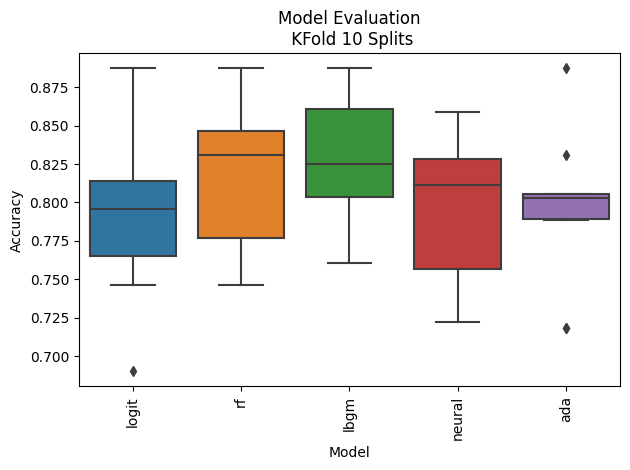

In [26]:

import seaborn as sns

g = sns.boxplot(data=kfold_results)
g.set_title('Model Evaluation\n KFold 10 Splits')
g.set_xlabel('Model')
g.set_ylabel('Accuracy')
g.set_xticklabels(names, rotation=90)
g.get_figure().tight_layout()

In [27]:
def print_model_stats(kfold_result, report):
    tn = report['confusion'][0][0] # True negative
    fp = report['confusion'][0][1] # False positive
    fn = report['confusion'][1][0] # False negative
    tp = report['confusion'][1][1] # True positive
    
    mr = 1 - report['accuracy'] # Misclassification rate
    tpr = tp / (fn + tp) # True positive rate
    fpr = fp / (tn + fp) # False positive rate
    spec = 1 - fpr # Specificity
    prec = tp / (fp + tp) # Precision    
    
    print('--------------------')
    print(report['name'])
    print('--------------------')
    print('F1 Score:        ', report['f1'])
    print('Accuracy:        ', report['accuracy'])
    print('Mean KFold (10): ', kfold_result.mean())
    print('Std. KFold (10): ', kfold_result.std())
    print('TPR:             ', tpr)
    print('FPR:             ', fpr)
    print('Specificity:     ', spec)
    print('Precision:       ', prec)
    print()
    
for kfold, report in zip(kfold_results, reports):
    print_model_stats(kfold_result, report)

--------------------
logit
--------------------
F1 Score:         0.7368421052631577
Accuracy:         0.8044692737430168
Mean KFold (10):  0.7952073552425666
Std. KFold (10):  0.04687906091614488
TPR:              0.7205882352941176
FPR:              0.14414414414414414
Specificity:      0.8558558558558559
Precision:        0.7538461538461538

--------------------
rf
--------------------
F1 Score:         0.7194244604316546
Accuracy:         0.7821229050279329
Mean KFold (10):  0.7952073552425666
Std. KFold (10):  0.04687906091614488
TPR:              0.7352941176470589
FPR:              0.1891891891891892
Specificity:      0.8108108108108107
Precision:        0.704225352112676

--------------------
lbgm
--------------------
F1 Score:         0.7014925373134329
Accuracy:         0.776536312849162
Mean KFold (10):  0.7952073552425666
Std. KFold (10):  0.04687906091614488
TPR:              0.6911764705882353
FPR:              0.17117117117117117
Specificity:      0.8288288288288288
Prec

In [28]:
! pip install optuna

In [29]:

from sklearn.model_selection import KFold


def optimization_step(trial, name, train, y_train):
    
    pipe = None
    
    if name == "rf":
        rf = {
            'bootstrap': trial.suggest_categorical("bootstrap", choices=["gini", "entropy"]),
            'max_depth': trial.suggest_int("max_depth", 3, 20),
            'max_features': trial.suggest_float("max_features", 0.01, 1.0),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 3, 5),
            'min_samples_split': trial.suggest_int("min_samples_split", 3, 5),
            'n_estimators': trial.suggest_int("n_estimators", 200, 2000),
            "criterion": trial.suggest_categorical("criterion", choices=["gini", "entropy"])
        }
        
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", RandomForestClassifier(**rf, random_state=seed, n_jobs=-1))])
        
    if name == "lgbm":
        lgbm = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 120, step=20),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
        }
        
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LGBMClassifier(**lgbm, random_state=seed, n_jobs=-1))])
    
    if name == "neural":
        
        n_layers = trial.suggest_int('hidden_layer_sizes', 1, 4)
        layers = []
        for i in range(n_layers):
            layers.append(trial.suggest_int(f"hidden_layer_sizes_{i}", 1, 128, step=10))
    
        neural = {
            # 'hidden_layer_sizes': [layers],
            'activation': trial.suggest_categorical("activation", choices=['identity', 'logistic', 'tanh', 'relu']),
            'solver': trial.suggest_categorical("solver", choices=['sgd', 'adam', 'lbfgs']),
            'alpha': trial.suggest_float("alpha", 0.0001, 0.05),
            'max_iter': trial.suggest_int("max_iter", 200, 1000),
            'learning_rate': trial.suggest_categorical("learning_rate", choices=['constant','adaptive'])
        }
        
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", MLPClassifier(**neural, random_state=seed))])

    kfold = KFold(n_splits=5)
    accuracies = []
    
    for train_indices, test_indices in kfold.split(train):
        xtrain, ytrain = train.iloc[train_indices], y_train.iloc[train_indices] 
        x_test, y_test = train.iloc[test_indices], y_train.iloc[test_indices]
        
        pipe.fit(xtrain, ytrain)
        y_pred = pipe.predict(x_test)
            
        fold_accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(fold_accuracy)
        
    return -1 * np.mean(accuracies)
    
    
    

In [30]:
import optuna
from functools import partial

import warnings
warnings.simplefilter('ignore')

# for name, classifier in tmp_classifiers.items():
# for model in ["rf", "logit"]:
optimization_function = partial(optimization_step, name="rf", train=train, y_train=y_train)

study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=100)
    
print("=========================================================================================================================")
rf = study.best_params
print("=========================================================================================================================")

[I 2022-10-01 22:23:16,728] A new study created in memory with name: no-name-e099f23d-cab0-4e9b-8b55-f1f88896e8d5
[I 2022-10-01 22:23:34,810] Trial 0 finished with value: -0.8106372500738697 and parameters: {'bootstrap': 'gini', 'max_depth': 19, 'max_features': 0.08066459662806662, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1853, 'criterion': 'gini'}. Best is trial 0 with value: -0.8106372500738697.
[I 2022-10-01 22:23:49,105] Trial 1 finished with value: -0.8414360287599724 and parameters: {'bootstrap': 'entropy', 'max_depth': 12, 'max_features': 0.736606572320331, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1359, 'criterion': 'gini'}. Best is trial 1 with value: -0.8414360287599724.
[I 2022-10-01 22:23:58,198] Trial 2 finished with value: -0.8442332315571752 and parameters: {'bootstrap': 'gini', 'max_depth': 14, 'max_features': 0.7655102866529483, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 871, 'criterion': 'entropy'}. Best i

In [31]:
optimization_function = partial(optimization_step, name="lgbm", train=train, y_train=y_train)

study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=100)
    
print("=========================================================================================================================")
lgbm = study.best_params
print("=========================================================================================================================")

[I 2022-10-01 22:44:51,565] A new study created in memory with name: no-name-ddea466d-7b7f-4b57-b6ad-c72092ec7b87
[I 2022-10-01 22:44:53,179] Trial 0 finished with value: -0.8162218063626515 and parameters: {'n_estimators': 1192, 'learning_rate': 0.15971146437091957, 'num_leaves': 120, 'max_depth': 4}. Best is trial 0 with value: -0.8162218063626515.
[I 2022-10-01 22:44:54,581] Trial 1 finished with value: -0.8273909189402147 and parameters: {'n_estimators': 454, 'learning_rate': 0.034003218477783884, 'num_leaves': 60, 'max_depth': 19}. Best is trial 1 with value: -0.8273909189402147.
[I 2022-10-01 22:44:56,587] Trial 2 finished with value: -0.8260218654584852 and parameters: {'n_estimators': 876, 'learning_rate': 0.10495027814448395, 'num_leaves': 60, 'max_depth': 8}. Best is trial 1 with value: -0.8273909189402147.
[I 2022-10-01 22:45:01,276] Trial 3 finished with value: -0.8176007091500048 and parameters: {'n_estimators': 1990, 'learning_rate': 0.056730018371589655, 'num_leaves': 40

In [32]:
optimization_function = partial(optimization_step, name="neural", train=train, y_train=y_train)

study = optuna.create_study(direction="minimize")
study.optimize(optimization_function, n_trials=100)
    
print("=========================================================================================================================")
neural = study.best_params
print("=========================================================================================================================")

[I 2022-10-01 22:47:01,693] A new study created in memory with name: no-name-994a60fb-63fd-4617-9d47-bf14eb46866f
[I 2022-10-01 22:47:05,082] Trial 0 finished with value: -0.8105387570176303 and parameters: {'hidden_layer_sizes': 2, 'hidden_layer_sizes_0': 61, 'hidden_layer_sizes_1': 71, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.024818840207004592, 'max_iter': 226, 'learning_rate': 'constant'}. Best is trial 0 with value: -0.8105387570176303.
[I 2022-10-01 22:47:15,545] Trial 1 finished with value: -0.8134049049542007 and parameters: {'hidden_layer_sizes': 2, 'hidden_layer_sizes_0': 11, 'hidden_layer_sizes_1': 31, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.018229469978840396, 'max_iter': 398, 'learning_rate': 'adaptive'}. Best is trial 1 with value: -0.8134049049542007.
[I 2022-10-01 22:47:25,551] Trial 2 finished with value: -0.8133753570373289 and parameters: {'hidden_layer_sizes': 2, 'hidden_layer_sizes_0': 61, 'hidden_layer_sizes_1': 71, 'activation': 'tanh', 

In [56]:
tmp_neural = neural
tmp_neural

{'hidden_layer_sizes': (41, 51),
 'activation': 'tanh',
 'solver': 'lbfgs',
 'alpha': 0.03159217287517449,
 'max_iter': 878,
 'learning_rate': 'adaptive'}

In [60]:

# n_layers = tmp_neural["hidden_layer_sizes"]
# # del neural["hidden_layer_sizes"]
# size_layer = []

# for n in range(n_layers[0]):
#     size_layer.append(neural[f"hidden_layer_sizes_{n}"])
#     del neural[f"hidden_layer_sizes_{n}"]

# # print(size_layer)
# neural["hidden_layer_sizes"] = tuple(size_layer)
# print(neural)

from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[("rf", RandomForestClassifier(**rf, random_state=seed, n_jobs=-1)), \
    ("lgbm", LGBMClassifier(**lgbm, random_state=seed, n_jobs=-1)), ("neural", MLPClassifier(**neural, random_state=seed))])


best_classifiers = {
    "rf": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", RandomForestClassifier(**rf, random_state=seed, n_jobs=-1))]),
    "lgbm": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LGBMClassifier(**lgbm, random_state=seed, n_jobs=-1))]),
    "neural": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", MLPClassifier(**neural, random_state=seed))]),
    "voting": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", voting)])
}

for name, classifier in best_classifiers.items():
    classifier.fit(train, y_train)
    
    print(f"{name}: -> {classifier.score(train, y_train)}")

rf: -> 0.8892005610098177
lgbm: -> 0.908835904628331
neural: -> 0.9046283309957924
voting: -> 0.9018232819074333


In [61]:

for name, classifier in best_classifiers.items():
    y_pred = classifier.predict(test)
        # 'confusion': confusion_matrix(y_test, predictions),
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name}. Accuracy -> {accuracy: .5f} | F1 -> {f1: .5f}")

rf. Accuracy ->  0.81006 | F1 ->  0.74242
lgbm. Accuracy ->  0.81564 | F1 ->  0.74809
neural. Accuracy ->  0.76536 | F1 ->  0.68657
voting. Accuracy ->  0.81006 | F1 ->  0.74242


In [62]:
test_copy = read_csv("test.csv")

def courtesy_title(name):
    return name.split(',')[-1].split('.')[0].strip()

def add_column_present(df, colname):
    df[f"{colname}_present"] =  np.where(df[colname] != 'NaN', 1, 0)
    
def group_courtesy_title(title):
    keep_titles = ('Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev')
    if title not in keep_titles:
        title = 'Other'
        
    return title

test_copy["title"] = test_copy['Name'].apply(courtesy_title)
passenger_ids = test_copy['PassengerId']
test_copy = test_copy.drop(["Name", "Cabin", "PassengerId"], axis=1)
test_copy['title'] = test_copy['title'].apply(group_courtesy_title)
colnames = ["Age", "Embarked"]
for colname in colnames:
    add_column_present(test_copy, colname)
    

test_copy.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title,Age_present,Embarked_present
0,3,male,34.5,0,0,330911,7.8292,Q,Mr,1,1
1,3,female,47.0,1,0,363272,7.0000,S,Mrs,1,1
2,2,male,62.0,0,0,240276,9.6875,Q,Mr,1,1
3,3,male,27.0,0,0,315154,8.6625,S,Mr,1,1
4,3,female,22.0,1,1,3101298,12.2875,S,Mrs,1,1


In [63]:
test_copy["Parch"] = test_copy['Parch'].replace(9, 6)

In [64]:
results = read_csv("gender_submission.csv")

results['PassengerId'] = passenger_ids
results["Survived"] = best_classifiers["voting"].predict(test_copy)

print(results.head())

results.to_csv(os.path.join(os.getcwd(), "dataset/gender_submission_voting.csv"), index=False)

KeyError: "['Is_child'] not in index"